# Linear Regression

In this lesson we will learn about linear regression. We will understand the basic math behind it, implement it in just NumPy and then in native [TensorFlow](https://www.tensorflow.org/install) and then with Keras.

<div align="left">
<a href="https://github.com/madewithml/basics/blob/master/notebooks/07_Linear_Regression/07_TF_Linear_Regression.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/basics/blob/master/notebooks/07_Linear_Regression/07_TF_Linear_Regression.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Overview

Our goal is to learn a linear model $\hat{y}$ that models $y$ given $X$. 

$\hat{y} = XW + b$
* $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DX1}$ 
* $b$ = bias | $\in \mathbb{R}^{1}$ 

* **Objective:**  Use inputs $X$ to predict the output $\hat{y}$ using a linear model. The model will be a line of best fit that minimizes the distance between the predicted (model's output) and target (ground truth) values. Training data $(X, y)$ is used to train the model and learn the weights $W$ using gradient descent.
* **Advantages:**
  * Computationally simple.
  * Highly interpretable.
  * Can account for continuous and categorical features.
* **Disadvantages:**
  * The model will perform well only when the data is linearly separable (for classification).
  * Usually not used for classification and only for regression.
* **Miscellaneous:** You can also use linear regression for binary classification tasks where if the predicted continuous value is above a threshold, it belongs to a certain class. But we will cover better techniques for classification in future lessons and will focus on linear regression for continuous regression tasks only.


# Generate data

We're going to create some simple dummy data to apply linear regression on. It's going to create roughly linear data (`y = 3.5X + noise`); the random noise is added to create realistic data that doesn't perfectly align in a line. Our goal is to have the model converge to a similar linear equation (there will be slight variance since we added some noise).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
SEED = 1234
NUM_SAMPLES = 50

In [0]:
# Set seed for reproducibility
np.random.seed(SEED)

In [0]:
# Generate synthetic data
def generate_data(num_samples):
    """Generate dummy data for linear regression."""
    X = np.array(range(num_samples))
    random_noise = np.random.uniform(-10,20,size=num_samples)
    y = 3.5*X + random_noise # add some noise
    return X, y

In [95]:
# Generate random (linear) data
X, y = generate_data(num_samples=NUM_SAMPLES)
data = np.vstack([X, y]).T
print (data[:5])

[[ 0.         -4.25441649]
 [ 1.         12.16326313]
 [ 2.         10.13183217]
 [ 3.         24.06075751]
 [ 4.         27.39927424]]


In [96]:
# Load into a Pandas DataFrame
df = pd.DataFrame(data, columns=['X', 'y'])
X = df[['X']].values
y = df[['y']].values
df.head()

,X,y
0,0.0,-4.254416
1,1.0,12.163263
2,2.0,10.131832
3,3.0,24.060758
4,4.0,27.399274


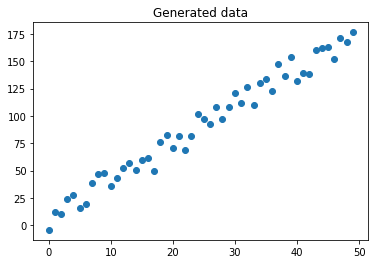

In [97]:
# Scatter plot
plt.title("Generated data")
plt.scatter(x=df['X'], y=df['y'])
plt.show()

# NumPy

Now that we have our data prepared, we'll first implement linear regression using just NumPy. This will let us really understand the underlying operations.

## Split data

Since our task is a regression task, we will randomly split our dataset into **three** sets: train, validation and test data splits.

* train: used to train our model.
* val : used to validate our model's performance during training.
* test: used to do an evaluation of our fully trained model.

In [0]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [0]:
# Shuffle data
if SHUFFLE:
    indices = list(range(NUM_SAMPLES))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

**NOTE**: Be careful not to shuffle X and y separately because then the inputs won't correspond to the outputs!

In [0]:
# Split indices
train_start = 0
train_end = int(0.7*NUM_SAMPLES)
val_start = train_end
val_end = int((TRAIN_SIZE+VAL_SIZE)*NUM_SAMPLES)
test_start = val_end

In [101]:
# Split data
X_train = X[train_start:train_end]
y_train = y[train_start:train_end]
X_val = X[val_start:val_end]
y_val = y[val_start:val_end]
X_test = X[test_start:]
y_test = y[test_start:]
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_test: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (35, 1), y_train: (35, 1)
X_val: (7, 1), y_test: (7, 1)
X_test: (8, 1), y_test: (8, 1)


## Standardize data

We need to standardize our data (zero mean and unit variance) or our models can optimize quickly when we are training.

$z = \frac{x_i - \mu}{\sigma}$
* $z$ = standardized value
* $x_i$ = inputs
* $\mu$ = mean
* $\sigma$ = standard deviation

In [0]:
def standardize_data(data, mean, std):
    return (data - mean)/std

In [0]:
# Determine means and stds
X_mean = np.mean(X_train)
X_std = np.std(X_train)
y_mean = np.mean(y_train)
y_std = np.std(y_train)

We need to treat the validation and test sets as if they were hidden datasets. So we only use the train set to determine the mean and std to avoid biasing our training process.

In [0]:
# Standardize
X_train = standardize_data(X_train, X_mean, X_std)
y_train = standardize_data(y_train, y_mean, y_std)
X_val = standardize_data(X_val, X_mean, X_std)
y_val = standardize_data(y_val, y_mean, y_std)
X_test = standardize_data(X_test, X_mean, X_std)
y_test = standardize_data(y_test, y_mean, y_std)

In [105]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train: mean: {np.mean(X_train, axis=0)[0]:.1f}, std: {np.std(X_train, axis=0)[0]:.1f}")
print (f"y_train: mean: {np.mean(y_train, axis=0)[0]:.1f}, std: {np.std(y_train, axis=0)[0]:.1f}")
print (f"X_val: mean: {np.mean(X_val, axis=0)[0]:.1f}, std: {np.std(X_val, axis=0)[0]:.1f}")
print (f"y_val: mean: {np.mean(y_val, axis=0)[0]:.1f}, std: {np.std(y_val, axis=0)[0]:.1f}")
print (f"X_test: mean: {np.mean(X_test, axis=0)[0]:.1f}, std: {np.std(X_test, axis=0)[0]:.1f}")
print (f"y_test: mean: {np.mean(y_test, axis=0)[0]:.1f}, std: {np.std(y_test, axis=0)[0]:.1f}")

X_train: mean: -0.0, std: 1.0
y_train: mean: 0.0, std: 1.0
X_val: mean: -0.5, std: 0.5
y_val: mean: -0.6, std: 0.5
X_test: mean: -0.6, std: 0.9
y_test: mean: -0.6, std: 0.9


## Weights

Our goal is to learn a linear model $\hat{y}$ that models $y$ given $X$. 

$\hat{y} = XW + b$
* $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DX1}$ 
* $b$ = bias | $\in \mathbb{R}^{1}$ 

1. Randomly initialize the model's weights $W$.

In [0]:
INPUT_DIM = X_train.shape[1] # X is 1-dimensional
OUTPUT_DIM = y_train.shape[1] # y is 1-dimensional

In [107]:
# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, OUTPUT_DIM)
b = np.zeros((1, 1))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (1, 1)
b: (1, 1)


## Model

2. Feed inputs $X$ into the model to receive the predictions $\hat{y}$.
  * $\hat{y} = XW + b$

In [108]:
# Forward pass [NX1] · [1X1] = [NX1]
y_pred = np.dot(X_train, W) + b
print (f"y_pred: {y_pred.shape}")

y_pred: (35, 1)


## Loss

3. Compare the predictions $\hat{y}$ with the actual target values $y$ using the objective (cost) function to determine the loss $J$. A common objective function for linear regression is mean squarred error (MSE). This function calculates the difference between the predicted and target values and squares it.

  * $J(\theta) = MSE = \frac{1}{N} \sum_{i-1}^{N} (y_i - \hat{y}_i)^2 $
    * ${y}$ = ground truth | $\in \mathbb{R}^{NX1}$
    * $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$

In [109]:
# Loss
N = len(y_train)
loss = (1/N) * np.sum((y_train - y_pred)**2)
print (f"loss: {loss:.2f}")

loss: 0.99


## Gradients

4. Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights.
  * $J(\theta) = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2  = \frac{1}{N}\sum_i (y_i - X_iW)^2 $
    * $\frac{\partial{J}}{\partial{W}} = -\frac{2}{N} \sum_i (y_i - X_iW) X_i = -\frac{2}{N} \sum_i (y_i - \hat{y}_i) X_i$
    * $\frac{\partial{J}}{\partial{b}} = -\frac{2}{N} \sum_i (y_i - X_iW)1 = -\frac{2}{N} \sum_i (y_i - \hat{y}_i)1$

In [0]:
# Backpropagation
dW = -(2/N) * np.sum((y_train - y_pred) * X_train)
db = -(2/N) * np.sum((y_train - y_pred) * 1)

**NOTE**: The gradient is the derivative, or the rate of change of a function. It's a vector that points in the direction of greatest increase of a function. For example the gradient of our loss function ($J$) with respect to our weights ($W$) will tell us how to change W so we can maximize $J$. However, we want to minimize our loss so we subtract the gradient from $W$. 

## Update weights

5. Update the weights $W$ using a small learning rate $\alpha$.
  * $W = W - \alpha\frac{\partial{J}}{\partial{W}}$
  * $b = b - \alpha\frac{\partial{J}}{\partial{b}}$

In [0]:
LEARNING_RATE = 1e-1

In [0]:
# Update weights
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db

**NOTE**: The learning rate $\alpha$ is a way to control how much we update the weights by. If we choose a small learning rate, it may take a long time for our model to train. However, if we choose a large learning rate, we may overshoot and our training will never converge. The specific learning rate depends on our data and the type of models we use but it's typically good to explore in the range of $[1e^{-8}, 1e^{-1}]$. We'll explore learning rate update stratagies in later lessons.

## Training

6. Repeat steps 2 - 5 to minimize the loss and train the model.

In [0]:
NUM_EPOCHS = 50

In [114]:
# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, OUTPUT_DIM)
b = np.zeros((1, ))

# Training loop
for epoch_num in range(NUM_EPOCHS):

    # Forward pass [NX1] · [1X1] = [NX1]
    y_pred = np.dot(X_train, W) + b

    # Loss
    loss = (1/len(y_train)) * np.sum((y_train - y_pred)**2)

    # show progress
    if epoch_num%10 == 0:
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}")

    # Backpropagation
    dW = -(2/N) * np.sum((y_train - y_pred) * X_train)
    db = -(2/N) * np.sum((y_train - y_pred) * 1)

    # Update weights
    W += -LEARNING_RATE * dW
    b += -LEARNING_RATE * db

Epoch: 0, loss: 0.990
Epoch: 10, loss: 0.039
Epoch: 20, loss: 0.028
Epoch: 30, loss: 0.028
Epoch: 40, loss: 0.028


## Evaluation

In [0]:
# Predictions 
pred_train = W*X_train + b
pred_test = W*X_test + b

In [116]:
# Train and test MSE
train_mse = np.mean((y_train - pred_train) ** 2)
test_mse = np.mean((y_test - pred_test) ** 2)
print (f"train_MSE: {train_mse:.2f}, test_MSE: {test_mse:.2f}")

train_MSE: 0.03, test_MSE: 0.01


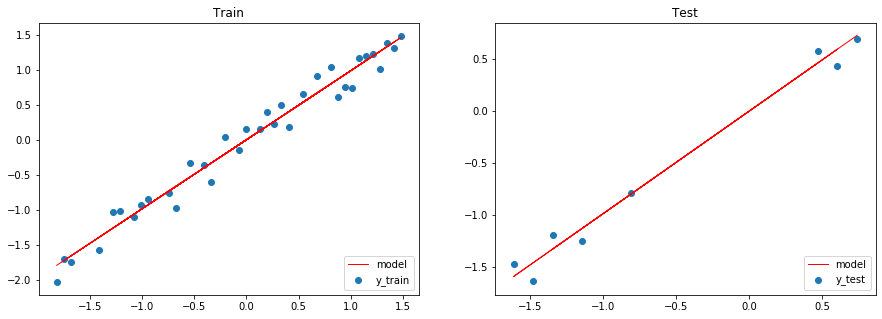

In [117]:
# Figure size
plt.figure(figsize=(15,5))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train, y_train, label='y_train')
plt.plot(X_train, pred_train, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test, y_test, label='y_test')
plt.plot(X_test, pred_test, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Show plots
plt.show()

## Interpretability

Since we standardized our inputs and outputs, our weights were fit to those standardized values. So we need to unstandardize our weights so we can compare it to our true weight (3.5).

Note that both X and y were standardized.

$\hat{y}_{scaled} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}x_{{scaled}_j}$
* $y_{scaled} = \frac{\hat{y} - \bar{y}}{\sigma_y}$
* $x_{scaled} = \frac{x_j - \bar{x}_j}{\sigma_j}$

$\frac{\hat{y} - \bar{y}}{\sigma_y} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}\frac{x_j - \bar{x}_j}{\sigma_j}$

$ \hat{y}_{scaled} = \frac{\hat{y}_{unscaled} - \bar{y}}{\sigma_y} = {b_{scaled}} + \sum_{j=1}^{k} {W}_{{scaled}_j} (\frac{x_j - \bar{x}_j}{\sigma_j}) $

$\hat{y}_{unscaled} = b_{scaled}\sigma_y + \bar{y} - \sum_{j=1}^{k} {W}_{{scaled}_j}(\frac{\sigma_y}{\sigma_j})\bar{x}_j + \sum_{j=1}^{k}{W}_{{scaled}_j}(\frac{\sigma_y}{\sigma_j})x_j $

In the expression above, we can see the expression $\hat{y}_{unscaled} = W_{unscaled}x + b_{unscaled} $ where

* $W_{unscaled} = \sum_{j=1}^{k}{W}_j(\frac{\sigma_y}{\sigma_j}) $

* $b_{unscaled} = b_{scaled}\sigma_y + \bar{y} - \sum_{j=1}^{k} {W}_j(\frac{\sigma_y}{\sigma_j})\bar{x}_j$

In [118]:
# Unscaled weights
W_unscaled = W * (y_std/X_std)
b_unscaled = b * y_std + y_mean - np.sum(W_unscaled*X_mean)
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled[0][0]:.1f}X + {b_unscaled[0]:.1f}") 

[actual] y = 3.5X + noise
[model] y_hat = 3.4X + 7.8


# TensorFlow

We will first implement linear regression using native TensorFlow without the ease of Keras. This will help us understand the hidden operations and also appreciate all the work that Keras does for us.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
# Set seed for reproducibility
tf.random.set_seed(SEED)

## Split data

When we're working with TensorFlow we normally use the scikit learn's [splitting functions](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) to split our data.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

The `train_val_test_split` function essentially splits our data twice. First, we separate out the test set. And then we separate the remaining other set into train and validation sets. 

In [124]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_test: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (35, 1), y_train: (35, 1)
X_val: (7, 1), y_test: (7, 1)
X_test: (8, 1), y_test: (8, 1)


## Standardize data

We can also use scikit learn to do [preprocessing and normalization](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing). 

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [0]:
# Apply scaler on training and test data
X_train = X_scaler.transform(X_train)
y_train = y_scaler.transform(y_train).ravel().reshape(-1, 1)
X_val = X_scaler.transform(X_val)
y_val = y_scaler.transform(y_val).ravel().reshape(-1, 1)
X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test).ravel().reshape(-1, 1)

In [128]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train: mean: {np.mean(X_train, axis=0)[0]:.1f}, std: {np.std(X_train, axis=0)[0]:.1f}")
print (f"y_train: mean: {np.mean(y_train, axis=0)[0]:.1f}, std: {np.std(y_train, axis=0)[0]:.1f}")
print (f"X_val: mean: {np.mean(X_val, axis=0)[0]:.1f}, std: {np.std(X_val, axis=0)[0]:.1f}")
print (f"y_val: mean: {np.mean(y_val, axis=0)[0]:.1f}, std: {np.std(y_val, axis=0)[0]:.1f}")
print (f"X_test: mean: {np.mean(X_test, axis=0)[0]:.1f}, std: {np.std(X_test, axis=0)[0]:.1f}")
print (f"y_test: mean: {np.mean(y_test, axis=0)[0]:.1f}, std: {np.std(y_test, axis=0)[0]:.1f}")

X_train: mean: -0.0, std: 1.0
y_train: mean: 0.0, std: 1.0
X_val: mean: 0.1, std: 0.6
y_val: mean: 0.1, std: 0.7
X_test: mean: -0.3, std: 0.7
y_test: mean: -0.3, std: 0.6


## Weights

In [0]:
# Weights
W = tf.Variable(0.)
b = tf.Variable(0.)

## Model

In [0]:
# Model
def model(x):
    return x*W + b

In [131]:
# Forward pass
print (X_train[0])
print (model(X_train[0]))

[0.96849907]
tf.Tensor([0.], shape=(1,), dtype=float32)


## Loss

In [0]:
# Loss
def mean_squared_error(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred-y_true))

In [133]:
# Sample loss
print (f"loss: {mean_squared_error(model(X_train), y_train)}")

loss: 1.0


## Training

In [134]:
for epoch in range(NUM_EPOCHS):
    with tf.GradientTape() as tape:
        # Forward pass
        y_pred = model(X_train)

        # Loss
        train_loss = mean_squared_error(y_pred=y_pred, y_true=y_train)
    
    # Gradients
    gradients = tape.gradient(train_loss, [W, b])

    # Update weights
    W.assign_sub(gradients[0] * LEARNING_RATE)
    b.assign_sub(gradients[1] * LEARNING_RATE)

    # Metrics
    if (epoch%5) == 0:
        print (f"Epoch: {epoch} | train_loss: {train_loss.numpy():.2f}")

Epoch: 0 | train_loss: 1.00
Epoch: 5 | train_loss: 0.13
Epoch: 10 | train_loss: 0.03
Epoch: 15 | train_loss: 0.02
Epoch: 20 | train_loss: 0.02
Epoch: 25 | train_loss: 0.02
Epoch: 30 | train_loss: 0.02
Epoch: 35 | train_loss: 0.02
Epoch: 40 | train_loss: 0.02
Epoch: 45 | train_loss: 0.02


## Evaluation

In [0]:
# Predictions 
pred_train = W*X_train + b
pred_test = W*X_test + b

In [136]:
# Train and test MSE
train_mse = np.mean((y_train - pred_train) ** 2)
test_mse = np.mean((y_test - pred_test) ** 2)
print (f"train_MSE: {train_mse:.2f}, test_MSE: {test_mse:.2f}")

train_MSE: 0.02, test_MSE: 0.01


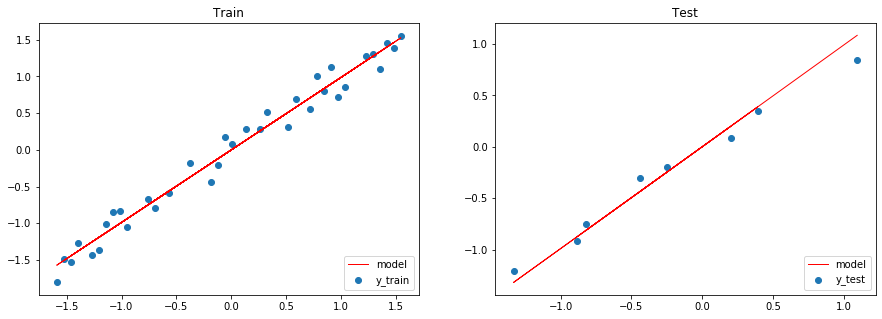

In [137]:
# Figure size
plt.figure(figsize=(15,5))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train, y_train, label='y_train')
plt.plot(X_train, model(X_train), color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test, y_test, label='y_test')
plt.plot(X_test, model(X_test), color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Show plots
plt.show()

## Interpretability

In [138]:
# Unscaled weights
W_unscaled = W.numpy() * (y_std/X_std)
b_unscaled = b.numpy() * y_std + y_mean - np.sum(W_unscaled*X_mean)
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled:.1f}X + {b_unscaled:.1f}") 

[actual] y = 3.5X + noise
[model] y_hat = 3.4X + 7.6


# TensorFlow + Keras

Now that we've implemented linear regression with Numpy and native TensorFlow, let's do the same with TensorFlow + Keras.

## Weights

We will be using [Dense layers](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense) in our MLP implementation. The layer applies an activation function on the dot product of the layer's inputs and its weights.

$ z = \text{activation}(XW)$ 

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

In [140]:
x = Input(shape=(INPUT_DIM,))
fc = Dense(units=OUTPUT_DIM, activation='linear')
z = fc(x)
W, b = fc.weights
print (f"z {z.shape} = x {x.shape} · W {W.shape} + b {b.shape}")

z (None, 1) = x (None, 1) · W (1, 1) + b (1,)


## Model

Our goal is to learn a linear model $\hat{y}$ that models $y$ given $X$. 

$\hat{y} = XW + b$
* $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DX1}$ 
* $b$ = bias | $\in \mathbb{R}^{1}$ 

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [0]:
class LinearRegression(Model):
    def __init__(self, output_dim):
        super(LinearRegression, self).__init__(name='linear_regression')
        self.fc1 = Dense(units=output_dim, activation='linear', name='W')
    
    def call(self, x_in, training=False):
        y_pred = self.fc1(x_in)
        return y_pred
    
    def summary(self, input_shape):
        x_in = Input(shape=input_shape, name='X')
        summary = Model(inputs=x_in, outputs=self.call(x_in), name=self.name)
        return plot_model(summary, show_shapes=True) # forward pass

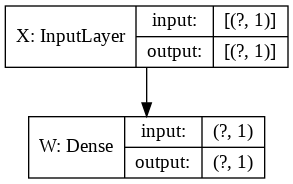

In [143]:
# Initialize model
model = LinearRegression(output_dim=OUTPUT_DIM)
model.summary(input_shape=(INPUT_DIM,))

## Loss

In [0]:
from tensorflow.keras.losses import MeanSquaredError

In [145]:
mse = MeanSquaredError()
loss = mse([0., 0., 1., 1.], [1., 1., 1., 0.])
print('Loss: ', loss.numpy()) 

Loss:  0.75


## Metrics

In [0]:
from tensorflow.keras.metrics import MeanAbsolutePercentageError

In [147]:
metric = MeanAbsolutePercentageError()
metric.update_state([0.5, 0.5, 1., 1.], [0.5, 1., 1., 0.])
print('Final result: ', metric.result().numpy())

Final result:  50.0


## Optimizer

When we implemented linear regression with just NumPy, we used batch gradient descent to update our weights. But there are actually many different [gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/) to choose from and it depends on the situation. However, the [ADAM optimizer](https://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms/#adam) has become a standard algorithm for most cases. 

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
# Optimizer
optimizer = Adam(lr=LEARNING_RATE)

## Training

Here are the full list of options for [optimizer](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers), [loss](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses) and [metrics](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics).

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=MeanSquaredError(),
              metrics=[MeanAbsolutePercentageError()])

When we implemented linear regression from scratch, we used batch gradient descent to update our weights. This means that we calculated the gradients using the entire training dataset. We also could've updated our weights using stochastic gradient descent (SGD) where we pass in one training example one at a time. The current standard is mini-batch gradient descent, which strikes a balance between batch and stochastic GD, where we update the weights using a mini-batch of n (`BATCH_SIZE`) samples.

In [0]:
BATCH_SIZE = 10

In [152]:
# Training
history = model.fit(x=X_train, 
                    y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    verbose=1)

Train on 35 samples, validate on 7 samples
Epoch 1/50
35/35 [==============================] - 0s 8ms/sample - loss: 2.2032 - mean_absolute_percentage_error: 144.8060 - val_loss: 0.7335 - val_mean_absolute_percentage_error: 227.3441
Epoch 2/50
35/35 [==============================] - 0s 450us/sample - loss: 1.1970 - mean_absolute_percentage_error: 108.1093 - val_loss: 0.3955 - val_mean_absolute_percentage_error: 328.6021
Epoch 3/50
35/35 [==============================] - 0s 401us/sample - loss: 0.5289 - mean_absolute_percentage_error: 74.9418 - val_loss: 0.1668 - val_mean_absolute_percentage_error: 206.9364
Epoch 4/50
35/35 [==============================] - 0s 403us/sample - loss: 0.1644 - mean_absolute_percentage_error: 43.4698 - val_loss: 0.0530 - val_mean_absolute_percentage_error: 718.5472
Epoch 5/50
35/35 [==============================] - 0s 434us/sample - loss: 0.0381 - mean_absolute_percentage_error: 26.2976 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 983.8639
Ep

In [153]:
# Training metrics
print (f"metrics: {list(history.history.keys())}")
print (f"final val_loss: {history.history['val_loss'][-1]:.2f}")

metrics: ['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error']
final val_loss: 0.02


## Evaluation

In [0]:
# Predictions
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [155]:
# Train metrics
train_mse = tf.keras.metrics.MeanSquaredError()
train_mse.update_state(y_train, pred_train)
print(f'train_mse: {train_mse.result().numpy(): .2f}')

train_mse:  0.02


In [156]:
# Test metrics
test_mse = tf.keras.metrics.MeanSquaredError()
test_mse.update_state(y_test, pred_test)
print(f'test_mse: {test_mse.result().numpy(): .2f}')

test_mse:  0.01


Since we only have one feature, it's easy to visually inspect the model.

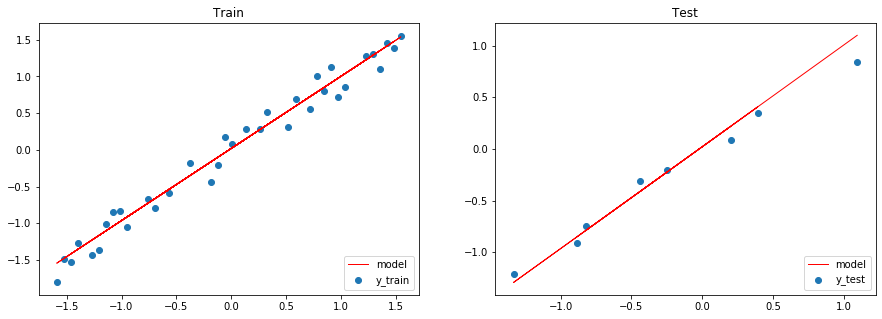

In [157]:
# Figure size
plt.figure(figsize=(15,5))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train, y_train, label='y_train')
plt.plot(X_train, pred_train, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test, y_test, label='y_test')
plt.plot(X_test, pred_test, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Show plots
plt.show()

## Inference

After training a model, we can use it to predict on new data.

In [0]:
# Feed in your own inputs
sample_indices = [10, 15, 25]
X_infer = np.array(sample_indices, dtype=np.float32)
X_infer = X_scaler.transform(X_infer.reshape(-1, 1))

Recall that we need to unstandardize our predictions.

$ \hat{y}_{scaled} = \frac{\hat{y} - \mu_{\hat{y}}}{\sigma_{\hat{y}}} $

$ \hat{y} = \hat{y}_{scaled} * \sigma_{\hat{y}} + \mu_{\hat{y}} $

In [159]:
# Unstandardize predictions
pred_infer = model.predict(X_infer) * np.sqrt(y_scaler.var_) + y_scaler.mean_
for i, index in enumerate(sample_indices):
    print (f"{df.iloc[index]['y']:.2f} (actual) → {pred_infer[i][0]:.2f} (predicted)")

35.73 (actual) → 43.36 (predicted)
59.34 (actual) → 60.37 (predicted)
97.04 (actual) → 94.40 (predicted)


## Interpretability

Linear regression offers the great advantage of being highly interpretable. Each feature has a coefficient which signifies its importance/impact on the output variable y. We can interpret our coefficient as follows: by increasing X by 1 unit, we increase y by $W$ (~3.65) units. 

In [160]:
# Unstandardize coefficients 
W = model.layers[0].get_weights()[0][0][0]
b = model.layers[0].get_weights()[1][0]
W_unscaled = W * (y_scaler.scale_/X_scaler.scale_)
b_unscaled = b * y_scaler.scale_ + y_scaler.mean_ - np.sum(W_unscaled*X_scaler.mean_)
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled[0]:.1f}X + {b_unscaled[0]:.1f}") 

[actual] y = 3.5X + noise
[model] y_hat = 3.4X + 9.3


# Regularization

Regularization helps decrease overfitting. Below is L2 regularization (ridge regression). There are many forms of regularization but they all work to reduce overfitting in our models. With L2 regularization, we are penalizing the weights with large magnitudes by decaying them. Having certain weights with high magnitudes will lead to preferential bias with the inputs and we want the model to work with all the inputs and not just a select few. There are also other types of regularization like L1 (lasso regression) which is useful for creating sparse models where some feature cofficients are zeroed out, or elastic which combines L1 and L2 penalties. 

**Note**: Regularization is not just for linear regression. You can use it to regularize any model's weights including the ones we will look at in future lessons.

$ J(\theta) = = \frac{1}{2}\sum_{i}(X_iW - y_i)^2 + \frac{\lambda}{2}W^TW$

$ \frac{\partial{J}}{\partial{W}}  = X (\hat{y} - y) + \lambda W $

$W = W- \alpha\frac{\partial{J}}{\partial{W}}$
* $\lambda$ is the regularzation coefficient

In [0]:
from tensorflow.keras.regularizers import l2

In [0]:
L2_LAMBDA = 1e-2

In [0]:
class L2LinearRegression(Model):
    def __init__(self, l2_lambda, output_dim):
        super(L2LinearRegression, self).__init__(name='l2_linear_regression')
        self.fc1 = Dense(units=output_dim, activation='linear', 
                         kernel_regularizer=l2(l=l2_lambda), name='W')
        
    def call(self, x_in, training=False):
        y_pred = self.fc1(x_in)
        return y_pred
    
    def summary(self, input_shape):
        x_in = Input(shape=input_shape, name='X')
        summary = Model(inputs=x_in, outputs=self.call(x_in), name=self.name)
        return plot_model(summary, show_shapes=True) # forward pass

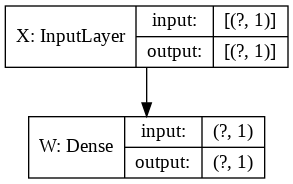

In [164]:
# Initialize model
model = L2LinearRegression(l2_lambda=L2_LAMBDA, output_dim=OUTPUT_DIM)
model.summary(input_shape=(INPUT_DIM,))

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=MeanSquaredError(),
              metrics=[MeanAbsolutePercentageError()])

In [166]:
# Training
model.fit(x=X_train, 
          y=y_train,
          validation_data=(X_val, y_val),
          epochs=NUM_EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=SHUFFLE,
          verbose=1)

Train on 35 samples, validate on 7 samples
Epoch 1/50
35/35 [==============================] - 0s 9ms/sample - loss: 0.3463 - mean_absolute_percentage_error: 64.7264 - val_loss: 0.0935 - val_mean_absolute_percentage_error: 132.8669
Epoch 2/50
35/35 [==============================] - 0s 430us/sample - loss: 0.0612 - mean_absolute_percentage_error: 28.1441 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 882.2163
Epoch 3/50
35/35 [==============================] - 0s 451us/sample - loss: 0.0474 - mean_absolute_percentage_error: 27.2072 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 866.8756
Epoch 4/50
35/35 [==============================] - 0s 358us/sample - loss: 0.0819 - mean_absolute_percentage_error: 36.9764 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 359.9240
Epoch 5/50
35/35 [==============================] - 0s 394us/sample - loss: 0.0596 - mean_absolute_percentage_error: 34.5615 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 682.9621
Epoc

In [0]:
# Predictions
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [168]:
# Train metrics
train_mse = tf.keras.metrics.MeanSquaredError()
train_mse.update_state(y_train, pred_train)
print(f'train_mse: {train_mse.result().numpy(): .2f}')

train_mse:  0.02


In [169]:
# Test metrics
test_mse = tf.keras.metrics.MeanSquaredError()
test_mse.update_state(y_test, pred_test)
print(f'test_mse: {test_mse.result().numpy(): .2f}')

test_mse:  0.01


Regularization didn't make a difference in performance with this specific example because our data is generated from a perfect linear equation but for large realistic data, regularization can help our model generalize well.

---
Share and discover ML projects at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/basics"><img src="https://img.shields.io/github/stars/madewithml/basics.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             